This notebook seeks to calculate the corrected fourier components 

This notebook uses SageMath 10.1 Jupyter kernel for mathematical methods. I belive `numpy + scipy/sympy` will yield the same results

The below content is a paraphrase of what is in Daniel's analysis note. It is for personal learning purpose **only**.

# Direct Sampling of Fourier Components

For any function $f$, the average of that function over a closed interval is:

$$
\frac{\int_a^b w(x) f(x) d x}{\int_a^b w(x) d x} \tag{*}
$$

where $w(x)$ is the weight. Therefore, if we want to average the $\langle \cos 2 \phi \rangle$ with weight $\alpha(phi)$, where $\alpha$ is the weights for each fourier components satisfying $\alpha(\phi) = 1 + \alpha cos(2\phi)$ if we only consider the $2\phi$ coiefficient, then effectively, we need to calculate:

$$
2 \langle \cos 2 \phi \rangle _\alpha = 2 \frac{\int_{- \pi}^{\pi} (1 + \alpha \cos 2\phi) \cos 2 \phi d \phi}{\int_{-\pi}^{\pi} (1 + \alpha \cos 2 \phi) d\phi} = \alpha 
$$

Therefore, to get the coiefficient of the $\cos (2 \phi)$ components, we only need $2 \langle \cos 2\phi \rangle _\alpha$, which we can just use a `TProfile` to take an average instead of fitting the $\phi$ distribution.

# Correcting for Detector Effects and STAR Acceptance 
We can create another weight function that is different from $\alpha(\phi)$, say $w$.
If $w$ is $\phi$ independent, then it is trivial that we instanly have the conclusion:
$$
2 \langle \cos 2\phi \rangle _{\text{measured}} = \alpha
$$

However, the weight $w$ is indeed a function of $\phi$. We now denote the weight as $w(\phi)$ (assuming only correcting $\phi$). We can now apply $w(x) = w(\phi) \alpha(\phi)$, $f(x) = \cos 2 \phi$ and apply equation (*):
$$
2 \langle \cos 2\phi \rangle _{\text{measured}} = 2 \frac{\int_{-\pi}^{\pi} w(\phi) \alpha(\phi) \cos 2\phi d\phi}{\int_{-\pi}^{\pi} w(\phi) \alpha(\phi) d\phi} \tag{**}
$$
Now, we assume $w(\phi)= 1+ w_1 \cos\phi + w_2 \cos 2\phi + w_3 \cos 3\phi \dots$ We already defined $\alpha (\phi) = 1 + \alpha_1 \cos \phi + \alpha_2 \cos 2\phi + \alpha_3 \cos 3\phi \dots$. We can use any numerical tool to solve equation $(**)$, and convert from $\gamma_i \equiv 2\langle \cos i \phi \rangle _{\text{measured}}$ to $\alpha_i$ (note: lower orders of $a_i$ needs to be calculated first, so this is a iterative process).

For simplification, let's say we only onsider the $\cos 2\phi$ coiefficient as by mixing $\phi$, we can eliminate the odd harmonics, and let's say we are not yet intrested in $\cos 4\phi$:
$$
2 \gamma_2 = 2 \frac{\int_{- \pi}^{\pi} (1 + w_2 \cos 2\phi) (1 + \alpha_2 \cos 2\phi) \cos 2\phi d\phi}{\int_{-\pi}^{\pi} (1 + w_2 \cos 2\phi)(1 + \alpha_2 \cos 2\phi) d\phi} = 2\frac{(\alpha_2 + w_2)}{2 + \alpha_2 w_2}
$$
Because I am lazy and I have a computer:


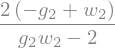

In [1]:
import sympy as sp 
import numpy as np
sp.init_printing(use_unicode=True, wrap_line=False, use_latex=True)
# define variables 
# type:ignore
a2,w2,g2,phi = sp.symbols('a2 w2 g2 phi')


# define numerator and denominator
denominator = 2 * sp.integrate((1 + w2 * sp.cos(2 * phi))*(1 + a2 * sp.cos(2 * phi))*sp.cos(2*phi), (phi,-sp.pi,sp.pi));
nemurator = sp.integrate((1 + w2* sp.cos(2 * phi))*(1 + a2* sp.cos(2 * phi)), (phi, -sp.pi, sp.pi));

# define equation to solve for
g2_equation = sp.Eq(g2, denominator / nemurator)

# solve for a2
solution = sp.solve(g2_equation, a2)

# print the solution
(solution[0].simplify())

We can see that $\alpha_2 = \frac{-2(\gamma_2 - w_2)}{g_2 w_2 - 2} \approx \gamma_2 - w_2$ at first degree approximation 

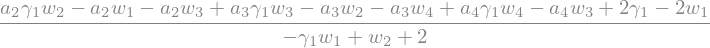

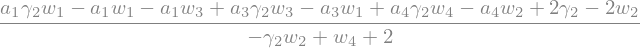

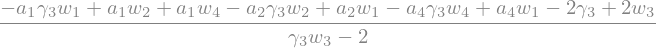

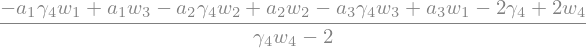

In [10]:
phi = sp.Symbol('phi')

n = 4 #nth degree approximation

# define variables
gamma_coefficients = {}
alpha_coefficients = {}
weight_coefficients = {}
for i in range (n):
    alpha_coefficients[f'a_{i+1}'] = sp.symbols(f'a_{i+1}')
    weight_coefficients[f'w_{i+1}'] = sp.symbols(f'w_{i+1}')

#define alpha(phi) w(phi) functions
alpha_function = 1
weight_function = 1

for i in range (n):
    alpha_function += alpha_coefficients[f'a_{i+1}'] * sp.cos ((i + 1) * phi)
    weight_function += weight_coefficients[f'w_{i+1}'] * sp.cos ((i + 1) * phi)
    

# fill gamma(alpha, weight)
for i in range (n):
    nemurator = 2 * sp.integrate(alpha_function * weight_function * sp.cos((i + 1)* phi),(phi, -sp.pi, sp.pi))
    denominator = sp.integrate(alpha_function * weight_function,(phi, -sp.pi, sp.pi))
    gamma_coefficients[f'g_{i+1}'] = (nemurator/denominator).simplify()
    
# start solving for alpha in terms of gamma, w
for i in range (n):
    gamma_equation = sp.Eq(sp.symbols(f"gamma_{i+1}"), gamma_coefficients[f'g_{i+1}'])
    alpha_coefficients[f'a_{i+1}'] = (sp.solve(gamma_equation, alpha_coefficients[f'a_{i+1}'])[0]).simplify()


for coieff in alpha_coefficients.values():
    display(coieff)


Here, we have obatined every $\alpha$ values derived from the four $\gamma$ equations. However, we note that we have a problem here, which is, when considering odd harmonics and harmonics from previous solutions, the $\alpha$ variables becomes mingled- they are no longer lienar.

We also note that $w_i$ are obtained from mixed events while $\gamma_i$ are obtained from actual measurements. Therefore, all the unkonwns are $\alpha$ only at this point. To this end, we should solve this problem numerically by using method of iteration. 

The implementation below finds the fixed points of all the $\alpha_i$. This *may not converge*. Specifically, our choice of the initial values **have to have the sum of the magnitude of all the partial derivatives to be less than one** 

The initial value is chosen to be simple subtraction from observed fourier components minus the mixed value fits. I chose this because this is the 1st degree approxiamtion for each even harmonics assuming odd harmonics are zero


## Iterative Methods:
To be added

In [3]:
# initial values. Note that the size of this array has to be the same as n
# These are basically values to modify from the average values taken from each momentum bins 
gamma_values_list = [0, 0.173, -0.025, -0.111]
w_values_list = [0, -1.068, 0.005, 0.478]

# substitute all the gamma and w values into the previous symbolic solution
subs_dict_non_alpha = {}
for i in range(n):
    subs_dict_non_alpha[sp.symbols(f'w_{i+1}')] = w_values_list[i]
    subs_dict_non_alpha[sp.symbols(f'gamma_{i+1}')] = gamma_values_list[i]

# Substitute non-alpha values
alpha_functions = [alpha_coefficients[f'a_{i+1}'].subs(subs_dict_non_alpha) for i in range(n)]

# Convert symbolic expressions to numerical functions
alpha_funcs_numerical = [sp.lambdify([sp.symbols(f'a_{i+1}') for i in range(n)], af) for af in alpha_functions]

# Initial values for alphas
alpha_values = np.array([g - w for g, w in zip(gamma_values_list, w_values_list)])

max_iteration = 100
convergence_threshold = 1e-6  
converged = False

for i in range(max_iteration):
    new_values = np.array([func(*alpha_values) for func in alpha_funcs_numerical])
    
    # Check for convergence
    changes = np.abs(new_values - alpha_values)
    if np.max(changes) < convergence_threshold:
        converged = True
        break
    
    alpha_values = new_values.copy()

if converged:
    print(f"Converged after {i+1} iterations.")
else:
    print(f"Reached maximum iterations without convergence.")
    
print(alpha_values)

Converged after 21 iterations.
[-0.01936546  0.911983   -0.02325772 -0.0466524 ]


## Error Bar Calculations:
Consider the average of the direct evaluation of Fourier components, we have the following errors (say, for $2 \phi$ component):

1. Statistical errors in measured $\cos 2 \phi$ (hi)
1. Statistical errors in mixed event $\cos 2 \phi$ (lo)

Because the averaging method does not involve in fitting, there is no systematic error here.

Now, if I can ignore second order terms and only express all the terms in $\gamma, w$, then the calculation is simple. Howver, the difficulty is that the fourier components really mixes with each other, and my no means are they independent from eachother. 

Maybe, instead of what I am doing here, I can make an estimation by:
1. Assume odd harmonics are zero (if we are purely intrested in even ones)
2. We isntantly have $\alpha_2 = \gamma_2 - w_2$
3. From our symbolic solver above, when solving for **solutions in terms of $\gamma, w$ only, the equation solver tends to fail**, we can make a simplication, for $n=4$, that the odd harmonics are zero. Using the results from above, we can try to calculate $\alpha_2, \alpha_4$ using this simplified formula:


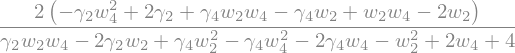

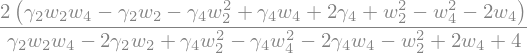

In [4]:
from sympy import symbols, Eq, solve

a_2, a_4, gamma_2, gamma_4, w_2, w_4 = symbols('a_2 a_4 gamma_2 gamma_4 w_2 w_4')

# Set up the equations
eq1 = Eq(a_2, (-2*gamma_2 + 2*w_2 + a_4*w_2 - gamma_2*a_4*w_4)/(-2 + gamma_2*w_2 - w_4))
eq2 = Eq(a_4, (-2*gamma_4 + a_2*w_2 - gamma_4*a_2*w_2 + 2*w_4)/(-2 + gamma_4*w_4))

# Solve eq1 for a_2 in terms of a_4
solution_for_a2 = solve(eq1, a_2)[0]



# Substitute this into eq2
eq2_substituted = eq2.subs(a_2, solution_for_a2)

solution_for_a4 = solve(eq2_substituted, a_4)

# Assuming there's at least one solution, and taking the first one:
solution_for_a2_final = solution_for_a2.subs(a_4, solution_for_a4[0])
solution_for_a4_final = solution_for_a4[0].subs(a_2, solution_for_a2_final)

display(solution_for_a2_final.simplify())
display(solution_for_a4_final.simplify())


and to calculate the error bar, we can do a total derivative sum on alpha:

$$
\Delta \alpha_2 \approx \frac{\partial \alpha_2}{\partial \gamma_2} \Delta \gamma_2 + \frac{\partial \alpha_2}{\partial w_2} \Delta w_2 + \text{same terms for index 4}
$$


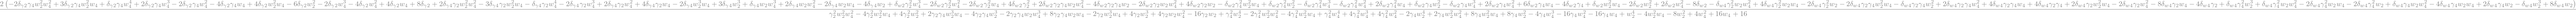

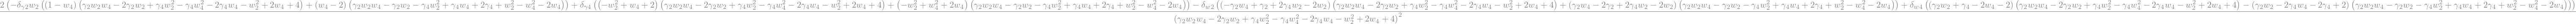

In [5]:
from sympy import  diff

# Variables
delta_gamma_2, delta_w_2, delta_gamma_4, delta_w_4 = symbols('delta_gamma_2 delta_w_2 delta_gamma_4 delta_w_4')


# Calculate the partial derivatives
partial_a2_gamma2 = diff(solution_for_a2_final, gamma_2)
partial_a2_gamma4 = diff(solution_for_a2_final, gamma_4)
partial_a2_w2 = diff(solution_for_a2_final, w_2)
partial_a2_w4 = diff(solution_for_a2_final, w_4)

partial_a4_gamma4 = diff(solution_for_a4_final, gamma_4)
partial_a4_w4 = diff(solution_for_a4_final, w_4)
partial_a4_gamma2 = diff(solution_for_a4_final, gamma_2)
partial_a4_w2 = diff(solution_for_a4_final, w_2)

# Calculate the estimated change in a_2 and a_4
delta_a2 = partial_a2_gamma2 * delta_gamma_2 + partial_a2_w2 * delta_w_2 + partial_a2_gamma4 * delta_gamma_4 + partial_a2_w4 *delta_w_4
delta_a4 = partial_a4_gamma4 * delta_gamma_4 + partial_a4_w4 * delta_w_4 + partial_a4_gamma2 * delta_gamma_2 + partial_a4_w2 *delta_w_2

display(delta_a2.simplify(), delta_a4.simplify())